In [1]:
%matplotlib inline

from collections import OrderedDict
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np

from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

import seaborn as sns

In [2]:
def std_anomalies(da):
    climatology = da.groupby('time.month').mean('time')
    std = da.groupby('time.month').std('time')

    anomalies = (da.groupby('time.month') - climatology)
    anomalies = anomalies.groupby('time.month') / std
    
    return anomalies

In [3]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_lnd_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'
ncfiles['rasm_ocn_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc'

ncfiles['$RASM_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.hmm.197909-201412.nc'


ds = xr.open_dataset(ncfiles['$RASM_{CONTROL}$'])

ncdata = {}
for k, v in ncfiles.items():
    ncdata[k] = xr.open_dataset(v)
    
ncdata['rasm_ocn_masks'] = ncdata['rasm_ocn_masks'].rename({'y': 'nj', 'x': 'ni'})
ncdata['$RASM_{CONTROL}$'] = ncdata['$RASM_{CONTROL}$'].rename({'a2xavg_nx': 'ni',
 'a2xavg_ny': 'nj',
 'l2xavg_nx': 'ni',
 'l2xavg_ny': 'nj',
 'x2aavg_nx': 'ni',
 'x2aavg_ny': 'nj',
 'x2lavg_nx': 'ni',
 'x2lavg_ny': 'nj'})

In [4]:
re = 6.37122e6
ncdata['rasm_domain']['area'] *= re * re  # m2

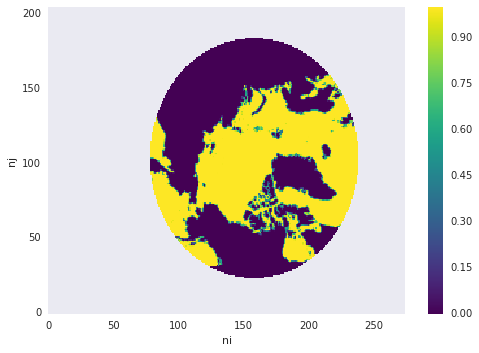

In [5]:
das = []
for k, da in ncdata['rasm_ocn_masks'].items():
    if k.startswith('mask_') and k not in ['mask_greenland_island', 'mask_centralarctic']:
        das.append(da)
        
ocn_mask = xr.concat(das, dim='mask').sum(dim='mask')

ocn_mask = ocn_mask.where(ocn_mask.latitude > 55)

ocn_mask.plot()


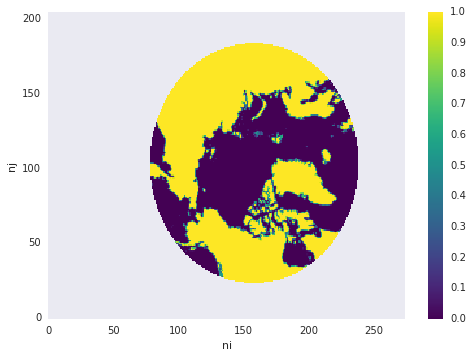

In [6]:
lnd_mask = ncdata['rasm_lnd_masks']['mask_active_land']
lnd_mask = lnd_mask.where(lnd_mask.yc > 55)

lnd_mask.plot()

In [7]:
total_precip = ds.a2xavg_Faxa_rainc + ds.a2xavg_Faxa_rainl + ds.a2xavg_Faxa_snowc + ds.a2xavg_Faxa_snowl
p = total_precip.sel(time=ds.indexes['time'].month > 9).rename({'a2xavg_ny': 'nj', 'a2xavg_nx': 'ni'})
p = p.resample('AS', how='mean', dim='time')

In [8]:
evap = ds.x2aavg_Faxx_evap * -1
e = evap.sel(time=ds.indexes['time'].month > 9).rename({'x2aavg_ny': 'nj', 'x2aavg_nx': 'ni'})
e = e.resample('AS', how='mean', dim='time')

In [9]:
e_anoms = std_anomalies(e.where(ocn_mask.where(lnd_mask.yc > 0) > 0))
p_anoms = std_anomalies(p.where(lnd_mask > 0))

solver = MultivariateEof([e_anoms.values, p_anoms.values],
                         weights=[ncdata['rasm_domain']['area'] * ocn_mask,
                                  ncdata['rasm_domain']['area'] * lnd_mask])

In [10]:
e_eofs, p_eofs = solver.eofs()

dims = list(e_anoms.dims)
dim0 = dims[0]
dims[0] = 'mode'

coords = OrderedDict(e_anoms.coords)
for d in ['time', 'month']:
    try:
        del coords[d]
    except KeyError:
        pass

e_eofs = xr.DataArray(e_eofs, coords=coords, dims=dims)
p_eofs = xr.DataArray(p_eofs, coords=coords, dims=dims)


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)
Self-intersection at or near point -1943672.0208036336 -746105.78469113226


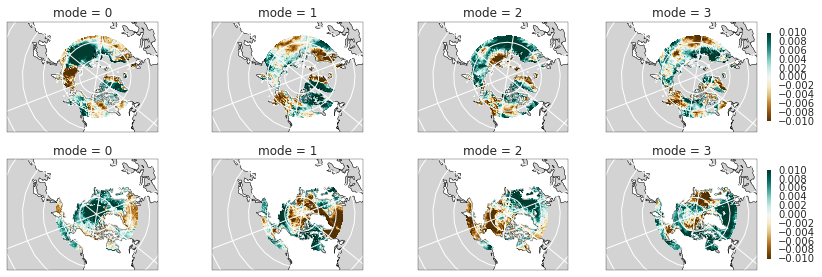

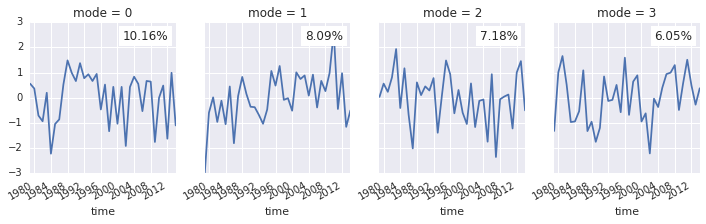

In [11]:
import cartopy
import cartopy.crs as ccrs
nmodes = 4
fig, axes = plt.subplots(nrows=2, ncols=nmodes, figsize=(12, 4),
                         subplot_kw=dict(projection=ccrs.NorthPolarStereo(-111, globe=False)))

kwargs = dict(x='longitude', y='latitude',
              transform=ccrs.PlateCarree(),
              add_colorbar=False, cmap='BrBG',
              vmin=-0.01, vmax=0.01)

for mode in range(nmodes):
    p_eofs.isel(mode=mode).plot.pcolormesh(ax=axes[0, mode], **kwargs)
    m = e_eofs.isel(mode=mode).plot.pcolormesh(ax=axes[1, mode], **kwargs)

for ax in axes.flat:
    ax.add_feature(cartopy.feature.OCEAN, zorder=0, color='lightgray')
    ax.add_feature(cartopy.feature.LAND, zorder=0, color='white', edgecolor='black')
    ax.coastlines()
    ax.gridlines()
    
plt.colorbar(ax=axes[0, -1], mappable=m, shrink=0.8)
plt.colorbar(ax=axes[1, -1], mappable=m, shrink=0.8)

fig.tight_layout()
    
    
pcs = solver.pcs(npcs=nmodes, pcscaling=1)

pcs = xr.DataArray(pcs, dims=('time', 'mode'),
                   coords={'time': e_anoms.time})
vf = solver.varianceFraction()

fig, axes = plt.subplots(nrows=1, ncols=nmodes, figsize=(12, 3), sharey=True)

with sns.axes_style('whitegrid'):
    for mode in range(nmodes):
        pcs.sel(mode=mode).plot(ax=axes[mode])
        axes[mode].text(0.95, 0.95, '%.2f%%' % (vf[mode] * 100),
            transform=axes[mode].transAxes,
            fontsize=12, va='top', ha='right', zorder=100,
            bbox=dict(boxstyle='square', facecolor='white', alpha=1, lw=0))

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


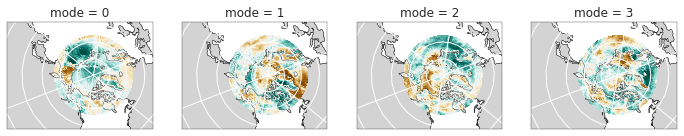

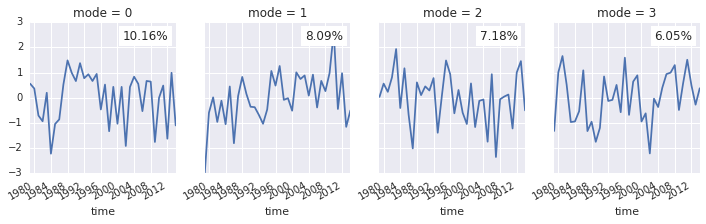

In [12]:
import cartopy
import cartopy.crs as ccrs
fig, axes = plt.subplots(nrows=1, ncols=nmodes, figsize=(12, 4),
                         subplot_kw=dict(projection=ccrs.NorthPolarStereo(-111, globe=False)))

kwargs = dict(x='longitude', y='latitude',
              transform=ccrs.PlateCarree(),
              add_colorbar=False)

for mode in range(nmodes):
    p_eofs.isel(mode=mode).plot.pcolormesh(ax=axes[mode], cmap='BrBG', **kwargs)
    e_eofs.isel(mode=mode).plot.pcolormesh(ax=axes[mode], cmap='BrBG', **kwargs)

for ax in axes.flat:
    ax.add_feature(cartopy.feature.OCEAN, zorder=0, color='lightgray')
    ax.add_feature(cartopy.feature.LAND, zorder=0, color='white', edgecolor='black')
    ax.coastlines()
    ax.gridlines()
    
    
pcs = solver.pcs(npcs=nmodes, pcscaling=1)

pcs = xr.DataArray(pcs, dims=('time', 'mode'),
                   coords={'time': e_anoms.time})
vf = solver.varianceFraction()

fig, axes = plt.subplots(nrows=1, ncols=nmodes, figsize=(12, 3), sharey=True)

with sns.axes_style('whitegrid'):
    for mode in range(nmodes):
        pcs.sel(mode=mode).plot(ax=axes[mode])
        axes[mode].text(0.95, 0.95, '%.2f%%' % (vf[mode] * 100),
            transform=axes[mode].transAxes,
            fontsize=12, va='top', ha='right', zorder=100,
            bbox=dict(boxstyle='square', facecolor='white', alpha=1, lw=0))

In [13]:
e_rcf, p_rcf = solver.reconstructedField(3)

e_rcf = xr.DataArray(e_rcf, coords=e_anoms.coords, dims=e_anoms.dims)
p_rcf = xr.DataArray(p_rcf, coords=p_anoms.coords, dims=p_anoms.dims)

In [14]:
import numpy as np
import scipy.stats as stats
from xarray.core.common import _full_like as full_like

def r2(da1, da2, mask):
    result = full_like(mask, fill_value=np.nan)
    for (y, x), val in np.ndenumerate(mask):
        if val > 0:
            _, _, r_value, _, _ = stats.linregress(
                da1[:, y, x], da2[:, y, x])
            result[y, x] = r_value**2
                
    return result

In [15]:
p_var_exp = r2(p_anoms, p_rcf, lnd_mask)
e_var_exp = r2(e_anoms, e_rcf, ocn_mask)

In [16]:
p_var_exp['xc'] = e_var_exp['longitude']  # fix longitude coord (don't know what went wrong)

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


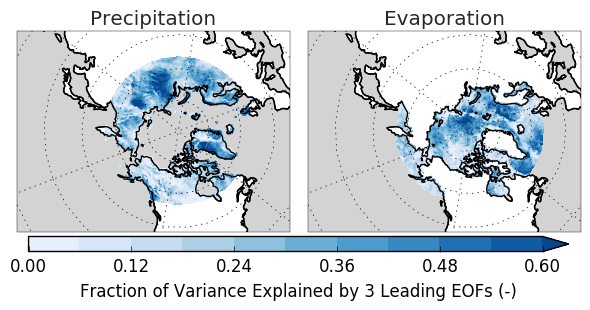

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3),
                         subplot_kw=dict(projection=ccrs.NorthPolarStereo(-111, globe=False)))

kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False, vmin=0, vmax=0.6, levels=10, cmap='Blues',)

m = p_var_exp.plot.pcolormesh(x='xc', y='yc', ax=axes[0], **kwargs)
axes[0].set_title('Precipitation')

m = e_var_exp.plot.pcolormesh(x='longitude', y='latitude', ax=axes[1], **kwargs)
axes[1].set_title('Evaporation')

for ax in axes.flat:
    ax.add_feature(cartopy.feature.OCEAN, zorder=0, color='lightgray')
    ax.add_feature(cartopy.feature.LAND, zorder=0, color='white', edgecolor='black')
    ax.coastlines()
    ax.gridlines()

fig.tight_layout()

ax3 = fig.add_axes([0.05, 0.1, 0.9, 0.05])
cbar = plt.colorbar(cax=ax3, mappable=m, orientation='horizontal')
cbar.set_label('Fraction of Variance Explained by 3 Leading EOFs (-)')

# fig.suptitle('Fraction of Variance Explained by leading 3 EOFs')


Attributing the Source of Variability of Precipitation
------

We have established that regions of the Arctic precipitation and evaporation fields vary together (EOF analysis above). This still doesn't tell us what the driving factors of precipitation variability are.  To answer that question, we are going to use a multiple linear regression approach where precipitation will be the response variable and will be regressed against poleward moisture transport and evaporation from the central arctic.